# DADA2
The DADA2 software finds Amplicon Sequence Variants (ASVs) from our raw reads. It does this by seeking to remove the errors produced by the sequencing platform.

This notebook describes the entire DADA2 workflow, and includes construction of a phylogenetic tree, and putting it all together in a phyloseq object.

## Workflow
* [Reads and sample names](#reads)
* [Filter and trim](#filter)
* [Learn errors](#errors)
* [ASV inference](#asv)
* [Merge reads](#merge)
* [Chimera removal](#chimera)
* [Checking dada2 workflow](#workflow)
* [Taxonomy](#taxonomy)
* [Phylogenetic tree](#tree)
* [Make phyloseq object](#physeq)

### Load packages

In [2]:
library(dada2)
library(ips)
library(phyloseq)

## Reads and sample names <a class="anchor" id="reads"></a>

Path to reads:

In [3]:
# Where are the (primer-trimmed) sequences
path <- "Seqs/Trimmed"

# Check that the files are there
list.files(path)

[1] "Filtered"           "SRX2198605_1.fastq" "SRX2198605_2.fastq"
[4] "SRX2198606_1.fastq" "SRX2198606_2.fastq"

Split names in forward and reverse reads. fnFs and fnRs now contains the names of the forward and reverse reads, respectively

In [4]:
fnFs <- sort(list.files(path, pattern="_1.fastq", full.names = TRUE))
fnRs <- sort(list.files(path, pattern="_2.fastq", full.names = TRUE))

Get sample names:

In [5]:
# Get sample names
sample.names <- sapply(strsplit(basename(fnFs), "_"), "[", 1)
sample.names

[1] "SRX2198605" "SRX2198606"

## Filter and trim <a class="anchor" id="filter"></a>
First step is to remove bad quality reads, and possibly truncate reads to remove bad quality endings

Inspect read quality (of the first sample only). First plot is forward reads, second plot is reverse reads. The cycle is equivalent to the basepair position in the read. The green line is the median (the red lines other quantiles), and the backround a heatmap (darker means more reads). We can see that the quality of the forward reads drops at around 230bp (which is expected given that our raw reads were 250 bp and we removed 19 bp of primer sequence), but for the reverse reads it's around 150bp (reverse reads are always lower quality). There also appears to be a sub-population of reads which have low quality (below 20)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


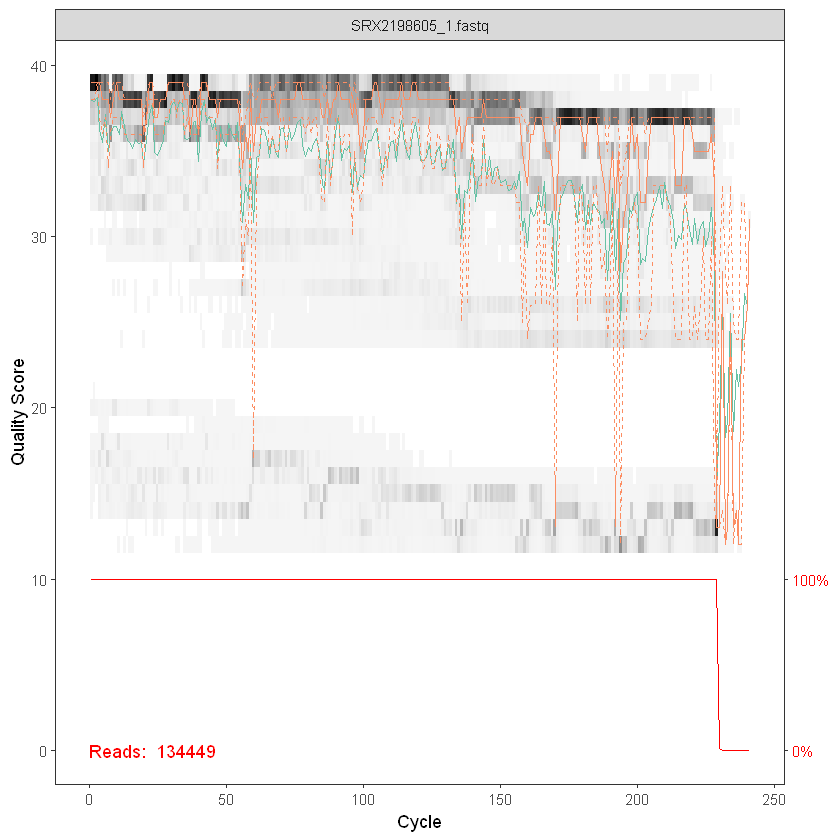

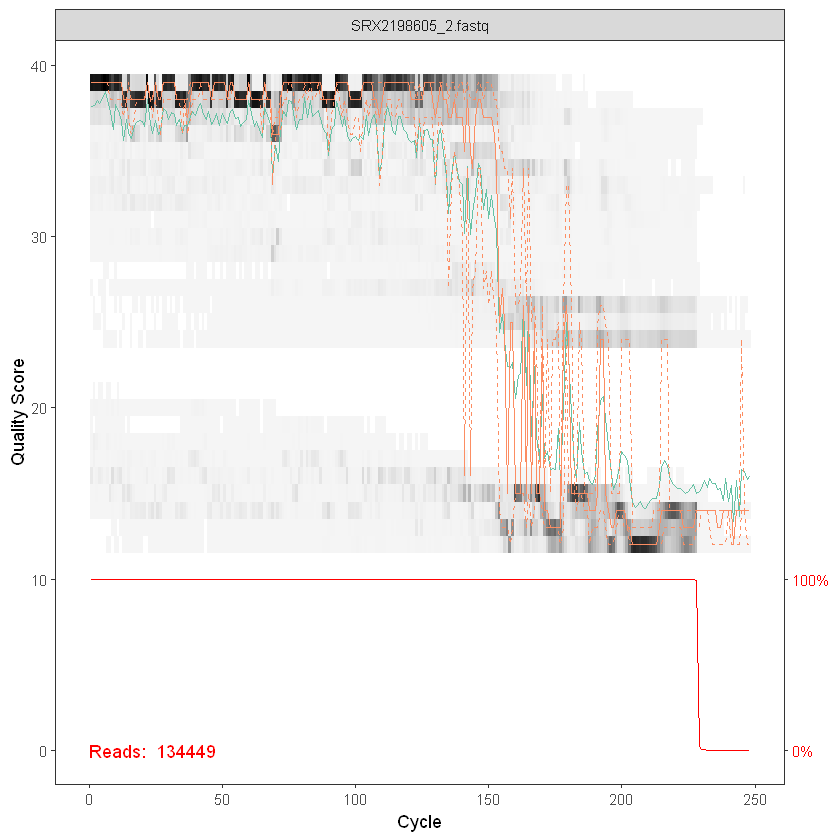

In [6]:
plotQualityProfile(fnFs[1])
plotQualityProfile(fnRs[1])

#### Filter and trim reads

There are many ways to filter and trim reads. See ?filterAndTrim for details.

Here we use to following parameters:
* Maximum expected error (maxEE) should be 2. I.e. reads with an overall low quality are removed.
* Truncate forward reads to 200 bp. Reads shorter than 200 bp are removed, the rest are truncated to 200 bp
* and truncate reverse reads to 150 bp. Reads shorter than 150 bp are removed, the rest are truncated to 150 bp
* Trim 6 bp from the left of (5') of each read. The 5' ends of reads in 16S rRNA gene amplicon sequences are highly conserved. Removing some of it usually improves chimera detection.
* Remove sequences that match phiX genome. In Illumina sequencing we always spike with phiX dna (to improve sequence quality), some of this phiX sequence might spillover to actual samples.


In [7]:
# Make names for where to put filtered reads
filtFs <- file.path(path, "Filtered", paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path(path, "Filtered", paste0(sample.names, "_R_filt.fastq.gz"))

out <- filterAndTrim(fnFs, filtFs, fnRs, filtRs,
                     maxEE=2,
                     truncLen=c(200,150),
                     trimLeft=6,
                     rm.phix=TRUE)

In [8]:
# How many reads were removed
out

,reads.in,reads.out
SRX2198605_1.fastq,134449,115160
SRX2198606_1.fastq,58532,18660


### Chossing parameters
When choosing filtering and trimming parameters (especially truncation) always have the length of the sequenced region in mind; there should be enough length left to merge the forward and reverse read. For example, for these samples the 16S rRNA gene V4 region primers 515F and 806R were used. This region spans 291 bp (in *E. coli*), which is 252 bp after removing primers. Our reads have a combined length of 350 bp (after truncation, trimLeft should be ignored). This gives and overlap region of 98 bp. If we have sequenced the V3-V4 region using the 341F primer instead of the 515F, we would have no overlap left with these truncation parameters, which would give problems in the merging step.

## Learn errors <a class="anchor" id="errors"></a>
DADA2 will try to learn the error rates from the reads, such that errors can be corrected

In [9]:
errF <- learnErrors(filtFs)
errR <- learnErrors(filtRs)

25961080 total bases in 133820 reads from 2 samples will be used for learning the error rates.
19270080 total bases in 133820 reads from 2 samples will be used for learning the error rates.


Plot Error profiles (of forward reads). Each panel is a subtitution error, for example A2C, is the error by which an A is converted to a C. The red lines are the expected error rates. The red points and line are observed. The expected and observed should follow each other somewhat.

Warning message:
"Transformation introduced infinite values in continuous y-axis"Warning message:
"Transformation introduced infinite values in continuous y-axis"

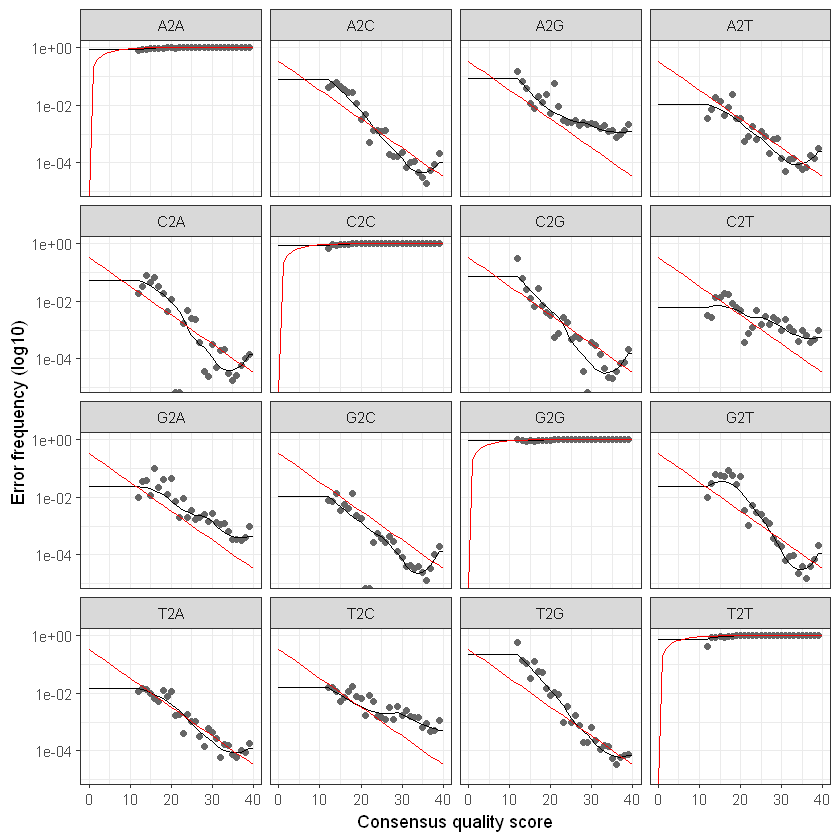

In [10]:
plotErrors(errF, nominalQ=TRUE)

## ASV inference <a class="anchor" id="asv"></a>
First step in inferring ASVs is to dereplicate, which means to remove duplicates

In [11]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)

# Name the derep objects by the sample names
names(derepFs) <- sample.names
names(derepRs) <- sample.names

Dereplicating sequence entries in Fastq file: Seqs/Trimmed/Filtered/SRX2198605_F_filt.fastq.gz
Encountered 14044 unique sequences from 115160 total sequences read.
Dereplicating sequence entries in Fastq file: Seqs/Trimmed/Filtered/SRX2198606_F_filt.fastq.gz
Encountered 7064 unique sequences from 18660 total sequences read.
Dereplicating sequence entries in Fastq file: Seqs/Trimmed/Filtered/SRX2198605_R_filt.fastq.gz
Encountered 9183 unique sequences from 115160 total sequences read.
Dereplicating sequence entries in Fastq file: Seqs/Trimmed/Filtered/SRX2198606_R_filt.fastq.gz
Encountered 1663 unique sequences from 18660 total sequences read.


We can then infer the ASVs from the dereplicated reads, and the error rates

In [12]:
dadaFs <- dada(derepFs, err=errF)
dadaRs <- dada(derepRs, err=errR)

Sample 1 - 115160 reads in 14044 unique sequences.
Sample 2 - 18660 reads in 7064 unique sequences.
Sample 1 - 115160 reads in 9183 unique sequences.
Sample 2 - 18660 reads in 1663 unique sequences.


## Merge reads <a class="anchor" id="merge"></a>
We will then merge the forward and reverse reads. Remember that the minimum overlap should be in accordance with the filtering parameters used. See section on filtering above

In [13]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, minOverlap=20)

Convert to a sequence table:

In [14]:
seqtab <- makeSequenceTable(mergers)

Dimensions of table. First number is samples, second number is ASVs

In [15]:
dim(seqtab)

[1]   2 239

## Chimera removal <a class="anchor" id="chimera"></a>
Chimeras are the accidental merging of sequences during sequencing. One part of the read could come from one bacterium, and the other part from another bacterium. It is possible to remove most of these bioinformatically. As we can assume that chimeras are relatively rare, we can remove rare ASVs whose sequence seems to be a mix of two common ASVs.

In [16]:
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", verbose=TRUE)

Identified 176 bimeras out of 239 input sequences.


Check how many ASVs are left after chimera removal

In [17]:
dim(seqtab.nochim)

[1]  2 63

## Checking dada2 workflow <a class="anchor" id="workflow"></a>
It is important to check how many reads that have been removed by the different steps. If a single step removes many more reads than the others, something might be wrong in the parameters of the different steps.

How many reads are left after each step:

In [18]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, 
               sapply(dadaFs, getN), 
               sapply(dadaRs, getN), 
               sapply(mergers, getN), 
               rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", 
                     "denoisedR", "merged", "nonchim")
rownames(track) <- sample.names
track

,input,filtered,denoisedF,denoisedR,merged,nonchim
SRX2198605,134449,115160,114971,114904,110789,105713
SRX2198606,58532,18660,18647,18638,18595,18335


Convert to percentages:

In [19]:
track[, 1:6] /track[, 1] * 100

,input,filtered,denoisedF,denoisedR,merged,nonchim
SRX2198605,100,85.6533,85.51272,85.46289,82.40225,78.62684
SRX2198606,100,31.8800,31.85779,31.84241,31.76895,31.32475


It is clearly the filtering step which removes most. We might have been too harsh in removing low quality reads. However, the two samples are also different, and possibly the second sample is just of worse quality. 

Some rules of thump:
* Filtering step removes many reads: maxEE could be too high, or truncation too high.
* Denoising step removes many reads: Something is up with the error rates.
* Merging step removes many reads: minOverlap too high, or truncation too high.
* Chimera step removes many reads: trimLeft could be increased.

## Taxonomy <a class="anchor" id="taxonomy"></a>
Let's assign taxonomy to our ASVs

In [20]:
taxa <- assignTaxonomy(seqtab.nochim, "gtdb_trim.fa.gz")

Let's view check the taxonomy of first three ASVs. The taxonomy is to the right in the table.

In [21]:
taxa[1:3, ]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
GGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGCTTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCA,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NA
GGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGAAAACTTGAGTGCAGAAGAGGAAAGTGGAATTCCATGTGTAGCGGTGAAATGCGCAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTTTCTGGTCTGTAACTGACGCTGATGTGCGAAAGCGTGGGGATCA,Bacteria,Firmicutes,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,NA
GGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTTAATAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGTTAAACTTGAGTGCAGGAGAGAAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAGGAACACCAGTGGCGAAGGCGGCTTTTTGGCCTGTAACTGACACTGAGGCGCGAAAGCGTGGGGAGCA,Bacteria,Firmicutes,Bacilli,Staphylococcales,Gemellaceae,Gemella,Gemella_morbillorum(RS_GCF_900476045.1)


Note that the ASVs are named by their sequence. It is easier if the ASVs have shorter names, and the sequences are therefore usually run through a hash algorithm to give them unique shorter reproducible names.

In [22]:
# Extract sequences (to save them)
seqs <- Biostrings::DNAStringSet(getSequences(seqtab.nochim))

In [23]:
# New names
asv_new <- openssl::md5(getSequences(seqtab.nochim))

In [24]:
# Put in the new names for all objects
colnames(seqtab.nochim) <- asv_new
names(seqs) <- asv_new
rownames(taxa) <- asv_new

Look at taxonomy table again:

In [25]:
taxa[1:3, ]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
59220fa2a44ac51f2cb31b68a2e2ca90,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NA
a9e6fcda282cc26c0f9df33b908dcc17,Bacteria,Firmicutes,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,NA
86da44252df24bfdd187eeb0b0839bbc,Bacteria,Firmicutes,Bacilli,Staphylococcales,Gemellaceae,Gemella,Gemella_morbillorum(RS_GCF_900476045.1)


## Phylogenetic tree <a class="anchor" id="tree"></a>
Let's make a phylogenetic tree. First we have to align the sequences. Then, based on this alignment we can infer our tree.

Align sequences with mafft. mafft is a multiple alignment software. It is run outside of R, but we can use the mafft function from the ips package to run it from R.

In [26]:
seq.dna <- as.DNAbin(seqs)
align <- mafft(seq.dna, exec = "mafft")

Look at alignment. Each row is an ASV sequence, each column is a position in the alignment. The length of the alignment is expected to be around the length of the sequenced 16S rRNA gene region.

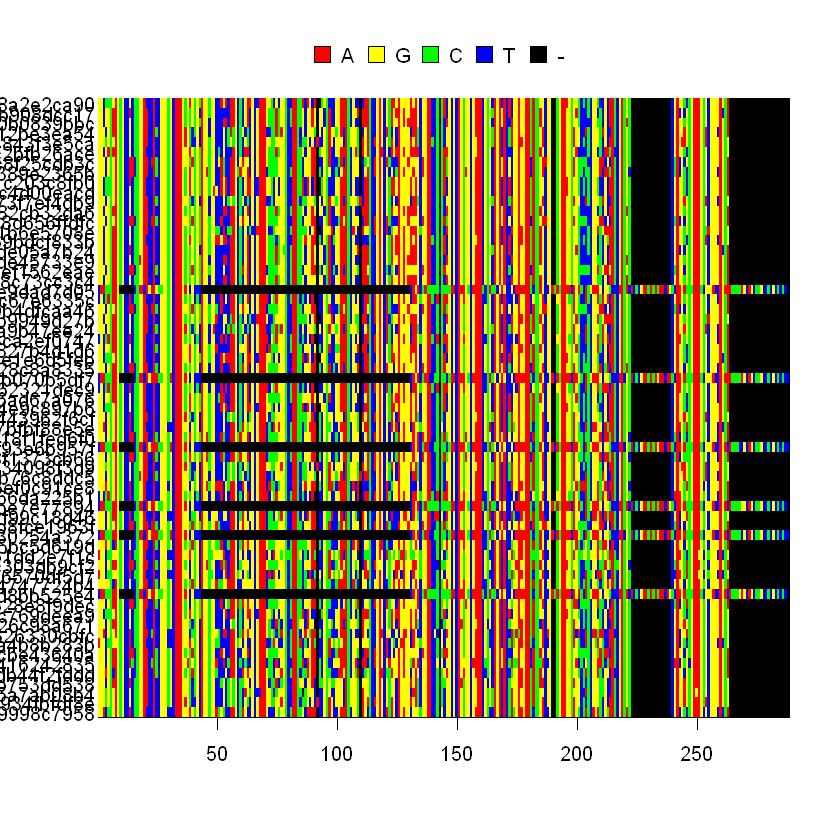

In [27]:
image(align)

6 of the ASVs clearly have weird sequences which do not align with the others. This is a good step to identify false ASVs. 

You can check for false ASVs by checking:
* Sequence length: Are some surprisingly short or long
* Taxonomy: Is it likely that you have an ASV which comes from an unknown Kingdom? Or unknown Phylum?
* Phylogenetic tree outliers: Is the sequences just very different from all the other 16S rRNA gene sequences

Count ASVs with different sequence lengths:

In [28]:
table(nchar(as.character(seqs)))


194 240 241 242 
  6  14  38   5 

6(!) are much shorter (194 bp) than the rest. What are their names:

In [29]:
names(seqs)[nchar(as.character(seqs)) < 200]

[1] "058413938b264e2113f57e1e9dad7d05" "ef698664814b0cd6fa8e071b070b5df7"
[3] "ca9373151510889c3f7590f93e6b957f" "6de1ee5e57a6f85761a46cbbe7e77894"
[5] "5cd2256e4a92f40b8bea27530254a372" "acf6b55ddce92c35ca86c34d8bb525e4"

Are there some ASVs with unknown Phylum?:

In [30]:
taxa[is.na(taxa[, "Phylum"]), ]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
058413938b264e2113f57e1e9dad7d05,Bacteria,NA,NA,NA,NA,NA,NA
ef698664814b0cd6fa8e071b070b5df7,Bacteria,NA,NA,NA,NA,NA,NA
ca9373151510889c3f7590f93e6b957f,Bacteria,NA,NA,NA,NA,NA,NA
6de1ee5e57a6f85761a46cbbe7e77894,Bacteria,NA,NA,NA,NA,NA,NA
5cd2256e4a92f40b8bea27530254a372,Bacteria,NA,NA,NA,NA,NA,NA
acf6b55ddce92c35ca86c34d8bb525e4,Bacteria,NA,NA,NA,NA,NA,NA


**Exactly the same 6 ASVs which were short also have unknown Phylum annotation. These are probably false.**

Let's remove the 6 bad ASVs and redo the alignment:

In [31]:
# Get names of bad ASVs
bad_asvs <- names(seqs)[nchar(as.character(seqs)) < 200]

# Remove from objects
seqtab.nochim <- seqtab.nochim[, !colnames(seqtab.nochim) %in% bad_asvs]
seqs <- seqs[!names(seqs) %in% bad_asvs]
taxa <- taxa[!rownames(taxa) %in% bad_asvs, ]

In [32]:
# Redo alignment
seq.dna <- as.DNAbin(seqs)
align <- mafft(seq.dna, exec = "mafft")

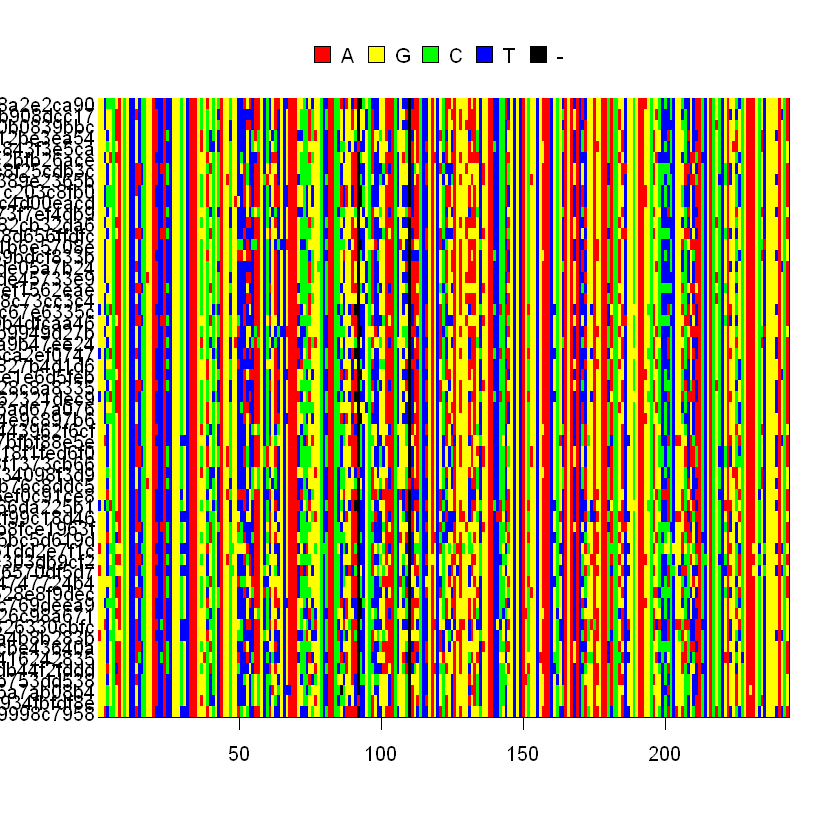

In [33]:
# Plot alignment
image(align)

Much better!

Let's create a phylogenetic tree with FastTree2

In [34]:
# We save the alignment as a fasta file
write.fas(align, file = "alignment.fasta")

In [35]:
# FastTree is also an external software that we run from within R
system2("fasttree", args = c("-nt", "-out tree.nwk", "alignment.fasta"))

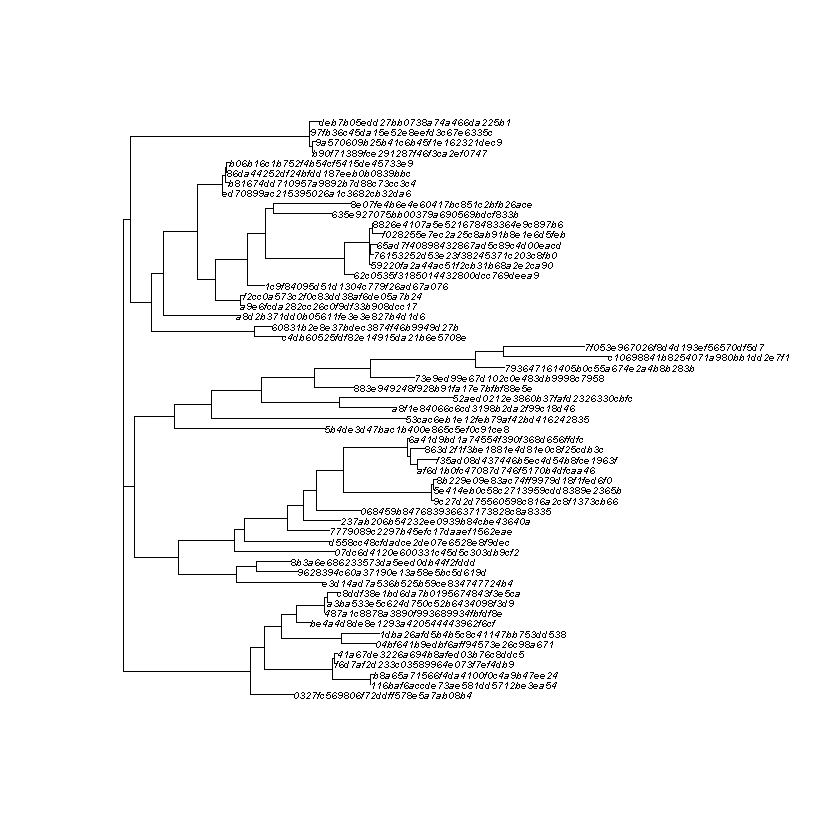

In [36]:
# Read the tree that FastTree made and plot it
# cex controls is size of labels in the plot
tree <- read.tree("tree.nwk")
plot(tree, cex = 0.5)

### Root tree
We should always root the tree. For this we need an outgroup. If we had Archaea in our samples, it would be a good choice. Here we use the Campylobacter phylum.

In [37]:
campy_asvs <- rownames(taxa)[taxa[, "Phylum"] == "Campylobacterota"]

In [38]:
# Root
tree <- root(tree, outgroup=campy_asvs, resolve.root=TRUE)

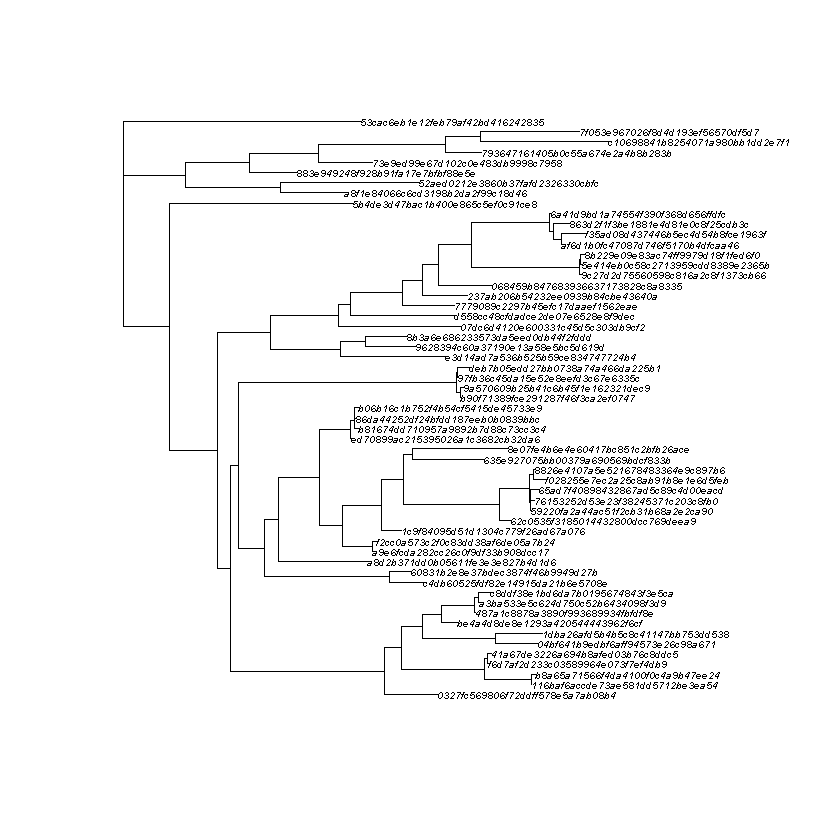

In [39]:
# Plot
plot(tree, cex = 0.5)

## Make phyloseq object <a class="anchor" id="physeq"></a>
Let's put all together in a phyloseq object

First, we need one more thing, the sample metadata:

In [41]:
# Read sample data
# Here we have information for the different samples
samp <- read.table("sampleData.csv", sep = ";", header = TRUE, row.names = 1)
print(samp)

             Type Patient     Date
SRX2198605 Airway       A 20150803
SRX2198606 Airway       B 20150205


#### Fix taxonomy table
If the taxonomic classifier cannot assign a certain taxonomic level it will write NA in the taxonomy table. NAs are a problem in the later analysis, expecially for tax agglomoration, and we therefore want to replace NAs with the most specific known taxonomic level.

In [42]:
taxa <- t(apply(taxa, 1, function(x) 
    if(sum(is.na(x))>0){
        c(x[!is.na(x)], 
          paste(colnames(taxa)[max(which(!is.na(x)))], rep(x[max(which(!is.na(x)))], sum(is.na(x))), sep="_"))} 
    else{x}))

Now we have a final taxonomic table:

In [43]:
taxa

59220fa2a44ac51f2cb31b68a2e2ca90,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Genus_Streptococcus
a9e6fcda282cc26c0f9df33b908dcc17,Bacteria,Firmicutes,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,Genus_Staphylococcus
86da44252df24bfdd187eeb0b0839bbc,Bacteria,Firmicutes,Bacilli,Staphylococcales,Gemellaceae,Gemella,Gemella_morbillorum(RS_GCF_900476045.1)
116baf6accde73ae581dd5712be3ea54,Bacteria,Actinobacteriota,Actinobacteria,Mycobacteriales,Mycobacteriaceae,Corynebacterium,Corynebacterium_propinquum(RS_GCF_000375525.1)
c8ddf38e1bd6da7b0195674843f3e5ca,Bacteria,Actinobacteriota,Actinobacteria,Actinomycetales,Micrococcaceae,Rothia,Rothia_mucilaginosa(RS_GCF_000175615.1)
8e07fe4b6e4e60417bc851c2bfb26ace,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Family_Carnobacteriaceae,Family_Carnobacteriaceae
863d2f1f3be1881e4d81e0c8f25cdb3c,Bacteria,Proteobacteria,Phylum_Proteobacteria,Phylum_Proteobacteria,Phylum_Proteobacteria,Phylum_Proteobacteria,Phylum_Proteobacteria
5e414eb0c58c2713959cdd8389e2365b,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Neisseriaceae,Neisseria,Neisseria_perflava(RS_GCF_002847985.1)
76153252d53e23f38245371c203c8fb0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Genus_Streptococcus
65ad7f40898432867ad5c89c4d00eacd,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Genus_Streptococcus
f6d7af2d233c03589964e073f7ef4db9,Bacteria,Actinobacteriota,Actinobacteria,Mycobacteriales,Mycobacteriaceae,Corynebacterium,Corynebacterium_sp000478175(RS_GCF_000478175.1)


Put it all together

In [44]:
# Collect everything in a phyloseq object
phy <- phyloseq(otu_table(t(seqtab.nochim), taxa_are_rows = TRUE),
                sample_data(samp),
                tax_table(taxa),
                phy_tree(tree),
                seqs)

# Check what the phyloseq object contains
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 57 taxa and 2 samples ]
sample_data() Sample Data:       [ 2 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 57 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 57 tips and 56 internal nodes ]
refseq()      DNAStringSet:      [ 57 reference sequences ]

Save it for use in other scripts

In [45]:
# Save phyloseq object for later analysis
save(phy, file = "physeq_test.RData")

# Save everything
save.image("dada2.RData")